In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from typing import Sequence
import itertools
import json
from bisect import bisect_left

In [2]:
diffs_file = 'diffs.json'
init_lob_file = 'init_lob.json'
trades_file = 'trades.json'
with open(diffs_file, 'r', encoding='utf-8') as file:
    diffs = json.load(file)
with open(init_lob_file, 'r', encoding='utf-8') as file:
    init_lob = json.load(file)
with open(trades_file, 'r', encoding='utf-8') as file:
    trades = json.load(file)

In [3]:
init_lob['bids'] = np.array(init_lob['bids']).astype(float)
init_lob['asks'] = np.array(init_lob['asks']).astype(float)

In [4]:
i = 0
while diffs[i]['u'] <= init_lob['lastUpdateId']: i += 1
diffs = diffs[i:]

In [5]:
i = 0
while trades[i]['E'] <= diffs[0]['E']: i += 1
trades = trades[i:]

In [20]:
MARKET_ID: int = 0
MM_ID: int = 1

BUY: int = 0
SELL: int = 1

PRICE_TICK: int = 2
AMOUNT_TICK: int = 8

class LimitOrder:
    def __init__(self, price: float, amount: float, side: int, trader_id: int):
        price = round(price, PRICE_TICK)
        amount = round(amount, AMOUNT_TICK)
        assert amount > 0
        assert price >= 0

        self.price = price
        self.amount = amount
        self.side = side
        self.trader_id = trader_id
    
    def __repr__(self):
        return f'LimitOrder({self.price}, {self.amount}, {self.side}, {self.trader_id})'


class PriceLevel:
    def __init__(self, first_limit_order: LimitOrder):
        self.price = first_limit_order.price
        self.amount = first_limit_order.amount
        self.side = first_limit_order.side
        self.traders_order = [first_limit_order]
    
    def __repr__(self):
        return f'PriceLevel({self.price}, {self.amount}, {self.side})'

    def add_limit_order(self, limit_order: LimitOrder): # trader_id: 0 - market, 1 - MM
        assert limit_order.price == self.price
        assert limit_order.side == self.side

        self.amount += limit_order.amount
        self.amount = round(self.amount, AMOUNT_TICK)
        if len(self.traders_order):
            if limit_order.trader_id == self.traders_order[-1].trader_id:
                self.traders_order[-1].amount += limit_order.amount
                self.traders_order[-1].amount = round(self.traders_order[-1].amount, AMOUNT_TICK)
            else:
                self.traders_order.append(limit_order)
        else:
            self.traders_order.append(limit_order)
        
    def execute_limit_order(self, amount: float):
        remain_amount = round(amount, AMOUNT_TICK)
        match_info = defaultdict(int) # trader_id - amount_sold

        for i, limit_order in enumerate(self.traders_order):
            match_info[limit_order.trader_id] += min(limit_order.amount, remain_amount)
            self.amount -= min(limit_order.amount, remain_amount)

            if remain_amount < limit_order.amount:
                limit_order.amount -= remain_amount
                limit_order.amount = round(limit_order.amount, AMOUNT_TICK)
                self.traders_order = self.traders_order[i:]
                remain_amount = 0
                break
            else:
                remain_amount -= limit_order.amount
        
        remain_amount = round(remain_amount, AMOUNT_TICK)
        self.amount = round(self.amount, AMOUNT_TICK)
        if self.amount == 0:
            self.traders_order = []

        return remain_amount, match_info

    def remove_liquidity(self, amount: float, user_id: int = MARKET_ID):


In [7]:
class MatchingEngine:
    def __init__(self):
        pass 
    
    @staticmethod
    def match_orders(price_levels: Sequence[PriceLevel], amount: float):
        remain_amount = amount
        price: float = 0.0
        remain_orders = []
        matches_info = defaultdict(list) # trader_info - [amount, price]

        for i, price_level in enumerate(price_levels):
            this_price: float = price_level.price
            this_amount: float = price_level.amount
            price += this_price * min(remain_amount, this_amount)
            remain_amount, this_match_info = price_level.eat_price_level(remain_amount)

            for k, v in this_match_info.items():
                trader_info = matches_info[k]
                if len(trader_info):
                    trader_info[0] += v
                    trader_info[1] += v * this_price
                else:
                    trader_info = [v, v * this_price]
                matches_info[k] = trader_info

            if not remain_amount:
                if price_level.amount:
                    remain_orders += [price_level]
                remain_orders += price_levels[i+1:]
                break

        return matches_info, remain_orders, remain_amount


class OrderBook:
    def __init__(self, bids: Sequence[PriceLevel] = [], asks: Sequence[PriceLevel] = [], 
                 matching_engine: MatchingEngine = MatchingEngine()):
        self.bids = sorted(bids, reverse=True, key=lambda x: x.price)
        self.asks = sorted(asks, key=lambda x: x.price)
        self.matching_engine = matching_engine
    
    def __repr__(self):
        ob_repr = ''

        min_len = min(len(self.bids), len(self.asks))
        for i in range(min_len):
            bid_str = repr(self.bids[i])
            ob_repr += bid_str + (36 - len(bid_str)) * ' ' + repr(self.asks[i]) + '\n'
        
        if len(self.bids) > min_len:
            remain_price_levels = self.bids[min_len:]
            indent = 0
        else:
            remain_price_levels = self.asks[min_len:]
            indent = 36
        
        for p_l in remain_price_levels:
            ob_repr += indent * ' ' + repr(p_l) + '\n'
        
        return ob_repr
    
    def get_state(self):
        return self.bids, self.asks
    
    def get_bids(self):
        return self.bids
    
    def get_asks(self):
        return self.asks
    
    def bid_price(self):
        return self.bids[0].price

    def ask_price(self):
        return self.asks[0].price

    def mid_price(self):
        return (self.bids[0].price + self.asks[0].price) / 2

    def bid_ask_spread(self):
        return self.asks[0].price - self.bids[0].price

    def market_depth(self):
        return self.asks[-1].price - self.bids[-1].price
    
    def update_state(self, diff):
        bids_update = diff[1]
        asks_update = diff[2]

        for bid in bids_update:
            limit_order = LimitOrder(bid[0], bid[1], BUY, MARKET_ID)

            bid_index = bisect_left(self.bids, limit_order, key=lambda x: x.price)
            if bid[0] == self.bids[bid_index].price:
                self.bids[bid_index].
            else:
                self.bids.insert(bid_index, PriceLevel(limit_order))
                


    def set_ask_order(self, limit_order: LimitOrder):
        index = len(self.bids)
        for i, price_level in enumerate(self.bids):
            if price_level.price < limit_order.price:
                index = i
                break

        eligible_bids = self.bids[:index]
        ineligible_bids = self.bids[index:]

        matches_info, remain_bids, remain_amount = self.matching_engine.match_orders(eligible_bids, limit_order.amount)
        new_bids: Sequence[PriceLevel] = remain_bids + ineligible_bids
        new_asks: Sequence[PriceLevel] = self.asks

        if remain_amount > 0:
            new_limit_order = LimitOrder(limit_order.price, remain_amount, 
                                         limit_order.side, limit_order.trader_id)

            index = len(new_asks)
            for i, price_level in enumerate(new_asks):
                if price_level.price >= limit_order.price:
                    index = i
                    break

            if index == len(new_asks):
                new_asks.append(PriceLevel(new_limit_order))
            elif new_asks[index].price != limit_order.price:
                new_asks.insert(index, PriceLevel(new_limit_order))
            else:
                new_asks[index].add_limit_order(new_limit_order)
        
        self.bids = new_bids
        self.asks = new_asks

        return matches_info
    
    def set_bid_order(self, limit_order: LimitOrder):
        index = len(self.asks)
        for i, price_level in enumerate(self.asks):
            if price_level.price > limit_order.price:
                index = i
                break
 
        eligible_asks = self.asks[:index]
        ineligible_asks = self.asks[index:]

        matches_info, remain_asks, remain_amount = self.matching_engine.match_orders(eligible_asks, limit_order.amount)
        new_asks: Sequence[PriceLevel] = remain_asks + ineligible_asks
        new_bids: Sequence[PriceLevel] = self.bids

        if remain_amount > 0:
            new_limit_order = LimitOrder(limit_order.price, remain_amount, 
                                         limit_order.side, limit_order.trader_id)

            index = len(new_bids)
            for i, price_level in enumerate(new_bids):
                if price_level.price <= limit_order.price:
                    index = i
                    break
            
            if index == len(new_bids):
                new_bids.append(PriceLevel(new_limit_order))
            elif new_bids[index].price != limit_order.price:
                new_bids.insert(index, PriceLevel(new_limit_order))
            else:
                new_bids[index].add_limit_order(new_limit_order)
        
        self.bids = new_bids
        self.asks = new_asks

        return matches_info

    def set_order(self, limit_order: LimitOrder):
        if limit_order.side == SELL:
            matches_info = self.set_ask_order(limit_order)
        elif limit_order.side == BUY:
            matches_info = self.set_bid_order(limit_order)
        else:
            raise Exception("WRONG SIDE!")
        
        return matches_info

def create_lob_init(lob_state: dict):
    bids_raw = lob_state['bids']
    asks_raw = lob_state['asks']

    bids = []
    asks = []

    for bid_raw in bids_raw:
        bid = PriceLevel(LimitOrder(bid_raw[0], bid_raw[1], BUY, MARKET_ID))
        bids.append(bid)
    
    for ask_raw in asks_raw:
        ask = PriceLevel(LimitOrder(ask_raw[0], ask_raw[1], SELL, MARKET_ID))
        asks.append(ask)
    
    return OrderBook(bids, asks)

SyntaxError: invalid syntax (3432787650.py, line 82)

In [8]:
class AvellanedaStoikov:
    def __init__(self, T: float, t_start: float, q0: float = 0, k: float = 1.5, 
                 sigma: float = 2, gamma: float = 0.1, q_max: float = 10**5):
        self.T = T
        self.t_start = t_start
        self.q0 = q0
        self.k = k
        self.sigma = sigma
        self.gamma = gamma
        self.q_max = q_max 

        self.q = self.q0

    def get_indifference_price(self, mid_price: float, timestamp):
        if timestamp > self.T:
            raise Exception("Time for trading is over")
        
        r = mid_price - self.q * self.gamma * self.sigma**2 * (self.T - timestamp) / (self.T - self.t_start)
        return r
    
    def get_optimal_spread(self, timestamp):
        if timestamp > self.T:
            raise Exception("Time for trading is over")
        
        optimal_spread = self.gamma * self.sigma**2 * (self.T - timestamp) / (self.T - self.t_start) + \
                         2 / self.gamma * np.log1p(self.gamma / self.k)

        return optimal_spread
        
    def update_inventory(self, q: float):
        self.q = q
    
    def get_bid_ask_price(self, lob_state: OrderBook, timestamp):
        r = self.get_indifference_price(lob_state.mid_price(), timestamp)
        optimal_spread = self.get_optimal_spread(timestamp)

        bid_price = r - optimal_spread / 2
        ask_price = r + optimal_spread / 2

        bid_price = np.round(bid_price, PRICE_TICK)
        ask_price = np.round(ask_price, PRICE_TICK)
    
        return bid_price, ask_price
    
    def bid_ask_limit_orders(self, lob_state: OrderBook, timestamp, q = None):
        if q is not None:
            self.update_inventory(q)
        bid_price, ask_price = self.get_bid_ask_price(lob_state, timestamp)

        bid_order = LimitOrder(bid_price, self.q_max, BUY, MM_ID)
        ask_order = LimitOrder(ask_price, self.q_max, SELL, MM_ID)

        return bid_order, ask_order

class Agent:
    def __init__(self, alpha: AvellanedaStoikov, BTC: float, USDT: float):
        self.alpha = alpha
        self.BTC = BTC
        self.USDT = USDT
    
    def __repr__(self):
        return f'{self.BTC}-{self.USDT}'

    def set_bid_ask(self, lob_state: OrderBook, timestamp):
        bid_order, ask_order = self.alpha.bid_ask_limit_orders(lob_state, timestamp, self.BTC)
        return bid_order, ask_order

NameError: name 'OrderBook' is not defined

In [ ]:
def cancel_my_bid_orders(order_book: OrderBook):
    bids = order_book.get_bids()

    for i, bid in enumerate(bids):
        new_price_level = None
        for j, trader_order in enumerate(bid.traders_order):
            if trader_order.trader_id == MM_ID:
                new_traders_order = bid.traders_order[:j] + bid.traders_order[j+1:]
                new_price_level = bid
                new_price_level.traders_order = new_traders_order
                new_price_level.amount -= trader_order.amount
                new_price_level.amount = round(new_price_level.amount, 3)
                break
        
        if new_price_level is not None:
            if new_price_level.amount > 0:
                bids[i] = new_price_level
            else:
                bids = bids[:i] + bids[i+1:]
    
    order_book.bids = bids

def cancel_my_ask_orders(order_book: OrderBook):
    asks = order_book.get_asks()

    for i, ask in enumerate(asks):
        new_price_level = None
        for j, trader_order in enumerate(ask.traders_order):
            if trader_order.trader_id == MM_ID:
                new_traders_order = ask.traders_order[:j] + ask.traders_order[j+1:]
                new_price_level = ask
                new_price_level.traders_order = new_traders_order
                new_price_level.amount -= trader_order.amount
                new_price_level.amount = round(new_price_level.amount, 3)
                break
        
        if new_price_level is not None:
            if new_price_level.amount > 0:
                asks[i] = new_price_level
            else:
                asks = asks[:i] + asks[i+1:]
    
    order_book.asks = asks

def cancel_my_orders(order_book: OrderBook):
    cancel_my_bid_orders(order_book)
    cancel_my_ask_orders(order_book)

In [9]:
class PnL_Counter:
    def __init__(self):
        self.pnl = 0.
        self.asset_purchased = 0.
        self.money_spent = 0.
        
    def change_pnl(self, prev_price, cur_price, balance):
        self.pnl += (cur_price - prev_price) * balance
    
    def update(self, asset_purchased, money_spent):
        self.asset_purchased += asset_purchased
        self.money_spent += money_spent

    def unrealized_pnl(self, cur_amount, ask_price):
        if self.asset_purchased > 0:
            self.pnl += cur_amount * (ask_price - self.money_spent / self.asset_purchased)
    
    def realized_pnl(self, amount_sold, price):
        if self.asset_purchased > 0:
            self.pnl += price - amount_sold * (self.money_spent / self.asset_purchased)

In [26]:
MARKET_LATENCY: int = 10
LOCAL_LATENCY: int = 30
LATENCY: int = MARKET_LATENCY + LOCAL_LATENCY

class Simulator:
    def __init__(self, diffs: Sequence(dict), trades: Sequence(dict), init_lob: dict,
                 agent: Agent, pnl_counter: PnL_Counter, time_end: float):
        self.diffs = diffs
        self.trades = trades
        self.init_lob = init_lob
        self.agent = agent
        self.pnl_counter = pnl_counter
        self.time_end = time_end

        self.preprocess_data()

    def preprocess_data(self):
        trades_by_diff = []

        trades_index = 0
        for v in self.diffs[1:]:
            time_to = v['E']
            trades_after_diff = []
            cur_trade = trades[trades_index]
            while cur_trade['T'] <= time_to:
                trades_after_diff.append((cur_trade['T'], float(cur_trade['p']), float(cur_trade['q'])))
                trades_index += 1
                cur_trade = trades[trades_index]
            trades_by_diff.append(trades_after_diff)
        
        self.trades = trades_by_diff

        new_diffs = []
        for diff in self.diffs:
            new_diffs.append((diff['E'], np.array(diff['b']).astype(float), 
                              np.array(diff['a']).astype(float)))

        self.diffs = new_diffs
        # self.order_book.update_state(new_diffs[0])

    def run(self):
        order_book = create_lob_init(self.init_lob)
        order_book.update_state(self.diffs[0])

        last_trade_price = self.order_book.ask_price()
        pnl_history = [0]
        mid_prices = [self.order_book.mid_price()]
        bid_prices = [self.order_book.bid_price()]
        ask_prices = [self.order_book.ask_price()]
        my_bid_prices = [self.order_book.bid_price()]
        my_ask_prices = [self.order_book.ask_price()]

        for i, diff in enumerate(self.diffs[1:]):
            cur_trades = self.trades[i]
            bid, ask = self.agent.set_bid_ask(order_book, diff['E'] + MARKET_LATENCY)
            
            
            order_book.update_state(diff)

        return {'pnl_history': pnl_history, 'mid_prices': mid_prices,
               'bid_prices': bid_prices, 'ask_prices': ask_prices,
               'my_bid_prices': my_bid_prices, 'my_ask_prices': my_ask_prices}
        # for timestamp in tqdm(self.ts_order[1:], leave=False, position=0):
        #     if timestamp[0] > self.time_end:
        #         break
            
        #     limit_orders_with_ts = []
        #     historical_orders = self.trades_history[(self.trades_history['remote_ts'] > prev_ts[0]) & (self.trades_history['remote_ts'] <= timestamp[0])]

        #     for _, order in historical_orders.iterrows():
        #         side = BUY if order['side'] == 'B' else SELL
        #         limit_order = LimitOrder(order['price'], order['amount'], side, MARKET_ID)
        #         last_history_lob_state.set_order(limit_order)
        #         limit_orders_with_ts.append((order['remote_ts'], limit_order))
                
                
        #     if timestamp[1] == REAL_TIMESTAMP:
        #         if timestamp[2] >= memory_size:
            #         order_book_memory.pop(timestamp[2] - memory_size)
            #     order_book_memory[timestamp[2]] = self.order_book

            #     new_history_lob_state = OrderBook().load_state(self.lob_history.iloc[timestamp[2]])
            #     unmatched_history_orders = get_unmatched_history_orders(new_history_lob_state, last_history_lob_state)
            #     deleted_history_orders = get_unmatched_history_orders(last_history_lob_state, new_history_lob_state)
            #     cancel_history_orders(self.order_book, deleted_history_orders)
            #     np.random.shuffle((unmatched_history_orders))
            #     limit_orders_with_ts += list(map(lambda x: (timestamp[0], x), unmatched_history_orders))
            #     last_history_lob_state = new_history_lob_state
                
            # elif timestamp[1] == LOCAL_TIMESTAMP:
            #     alpha_limit_orders = self.agent.set_bid_ask(order_book_memory[timestamp[2]], timestamp[0])
            #     alpha_order_ts = int(timestamp[0] + np.random.default_rng().exponential(scale=mean_latency))
            #     if alpha_limit_orders[0].price == last_alpha_bid_price and alpha_limit_orders[1].price == last_alpha_ask_price:
            #         alpha_limit_orders = None
            #         alpha_order_ts = None
            # else:
            #     raise Exception('WRONG TIMESTAMP')
            
            # if alpha_limit_orders is not None:
            #     if alpha_order_ts < timestamp[0]:
            #         index = 0
            #         for i, (ts, limit_order) in enumerate(limit_orders_with_ts):
            #             if ts > alpha_order_ts:
            #                 index = i
            #                 break
                    
            #         if alpha_limit_orders[0].price != last_alpha_bid_price:
            #             limit_orders_with_ts.insert(index, (alpha_order_ts, alpha_limit_orders[0]))
            #             last_alpha_bid_price = alpha_limit_orders[0].price
            #         if alpha_limit_orders[1].price != last_alpha_ask_price:
            #             limit_orders_with_ts.insert(index, (alpha_order_ts, alpha_limit_orders[1]))
            #             last_alpha_ask_price = alpha_limit_orders[1].price
                    
            #         alpha_limit_orders = None
            #         alpha_order_ts = None
            
            # for (_, limit_order) in limit_orders_with_ts:
            #     if limit_order.trader_id == MM_ID:
            #         if limit_order.side == BUY:
            #             cancel_my_bid_orders(self.order_book)
            #         elif limit_order.side == SELL:
            #             cancel_my_ask_orders(self.order_book)

            #     match_info = self.order_book.set_order(limit_order)

            #     if MM_ID in match_info:
            #         self.pnl_counter.change_pnl(last_trade_price, self.order_book.ask_price(), self.agent.BTC)
                    
            #         MM_data = match_info[MM_ID]
            #         if limit_order.side == BUY:
            #             self.agent.BTC -= MM_data[0]
            #             self.agent.USDT += MM_data[1]
            #             #self.pnl_counter.realized_pnl(MM_data[0], MM_data[1])
            #         elif limit_order.side == SELL:
            #             self.agent.BTC += MM_data[0]
            #             self.agent.USDT -= MM_data[1]
            #             #self.pnl_counter.update(MM_data[0], MM_data[1])
            #         else:
            #             raise Exception('ERROR SIDE')
                    
        #             last_trade_price = self.order_book.ask_price()
        #     if timestamp[1] == REAL_TIMESTAMP:
        #         pnl_history.append(self.pnl_counter.pnl)
        #         if len(self.order_book.get_bids()) and len(self.order_book.get_asks()):
        #             mid_prices.append(self.order_book.mid_price())
        #         else:
        #             mid_prices.append(mid_prices[-1])
                
        #         if len(self.order_book.get_bids()):
        #             bid_prices.append(self.order_book.bid_price())
        #         else:
        #             bid_prices.append(bid_prices[-1])
                
        #         if len(self.order_book.get_asks()):
        #             ask_prices.append(self.order_book.ask_price())
        #         else:
        #             ask_prices.append(ask_prices[-1])
        #         my_bid_prices.append(last_alpha_bid_price)
        #         my_ask_prices.append(last_alpha_ask_price)
        #     #self.pnl_counter.unrealized_pnl(self.agent.BTC, self.order_book.ask_price())
        #     prev_ts = timestamp
        # self.pnl_counter.change_pnl(last_trade_price, self.order_book.ask_price(), self.agent.BTC)
        # pnl_history.append(self.pnl_counter.pnl)

        # return {'pnl_history': pnl_history, 'mid_prices': mid_prices,
        #        'bid_prices': bid_prices, 'ask_prices': ask_prices,
        #        'my_bid_prices': my_bid_prices, 'my_ask_prices': my_ask_prices}

In [17]:
t0 = diffs[0]['E']
T = diffs[-1]['E']

pnl_counter = PnL_Counter()
order_book: OrderBook = create_lob_init(init_lob)
alpha = AvellanedaStoikov(T=T, t_start=t0, q0=0, k=2, sigma=5, gamma=0.3, q_max=1)
agent: Agent = Agent(alpha, 0, 0)
simulator: Simulator = Simulator(diffs, trades, agent, order_book, pnl_counter, T)

NameError: name 'Simulator' is not defined

In [21]:
run_data = simulator.run()

In [29]:
%load_ext line_profiler

In [28]:
%lprun -f simulator.run simulator.run()

Timer unit: 1e-09 s

Total time: 63.7706 s
File: /tmp/ipykernel_11289/1318133405.py
Function: run at line 31

Line #      Hits         Time  Per Hit   % Time  Line Contents
    31                                               def run(self):
    32         1       3200.0   3200.0      0.0          prev_ts = self.ts_order[0]
    33         1    4947398.0    5e+06      0.0          last_history_lob_state: OrderBook = OrderBook().load_state(self.lob_history.iloc[self.ts_order[0][2]])
    34         1    4688898.0    5e+06      0.0          self.order_book.load_state(self.lob_history.iloc[self.ts_order[0][2]])
    35         1        700.0    700.0      0.0          alpha_limit_orders = None
    36         1        500.0    500.0      0.0          alpha_order_ts = None
    37         1      10300.0  10300.0      0.0          last_alpha_ask_price, last_alpha_bid_price = self.order_book.ask_price(), self.order_book.bid_price() #hardcode. to not set new orders with same price
    38         1 

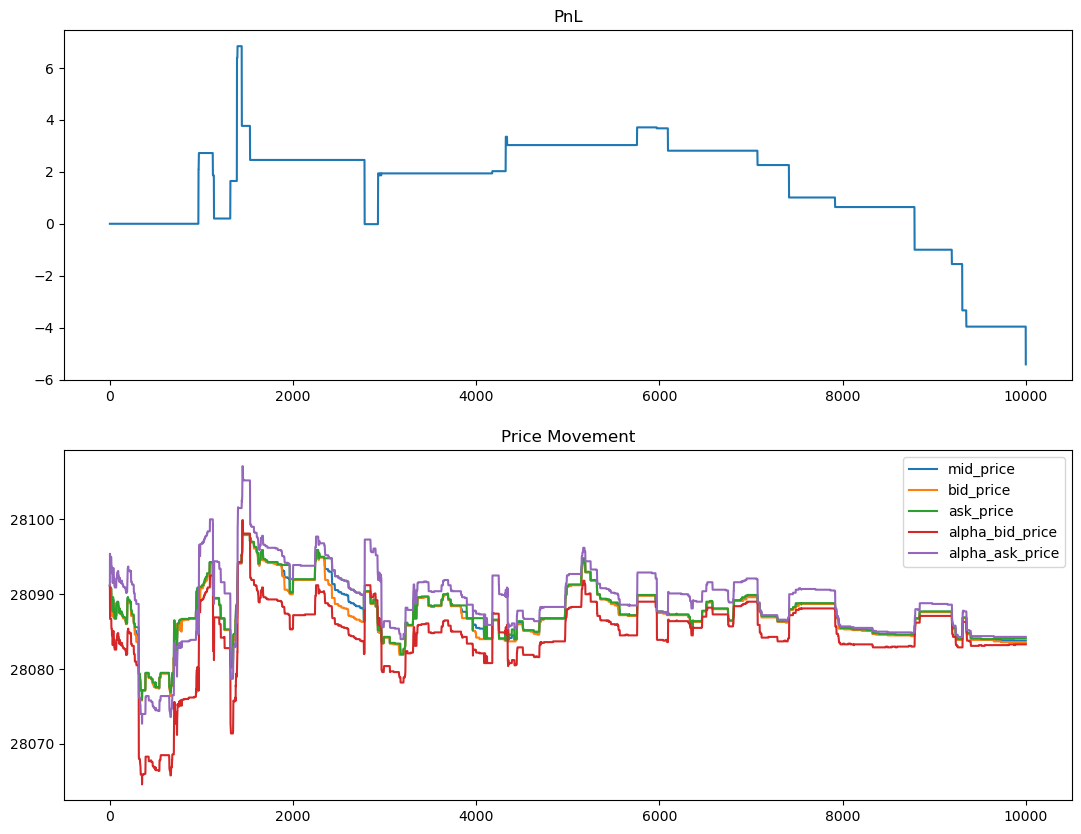

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(13, 10))

axes[0].plot(run_data['pnl_history'])
axes[0].set_title('PnL')

axes[1].plot(run_data['mid_prices'], label='mid_price')
axes[1].plot(run_data['bid_prices'], label='bid_price')
axes[1].plot(run_data['ask_prices'], label='ask_price')
axes[1].plot(run_data['my_bid_prices'], label='alpha_bid_price')
axes[1].plot(run_data['my_ask_prices'], label='alpha_ask_price')
axes[1].set_title('Price Movement')

plt.legend()
plt.show()

In [22]:
def run_simulations(alpha, num_runs: int = 10):
    profits = []
    qs = []

    for _ in range(num_runs):
        pnl_counter = PnL_Counter()
        order_book: OrderBook = OrderBook()
        agent: Agent = Agent(alpha, 0, 0)
        simulator: Simulator = Simulator(book_small, trades_small, agent, order_book, pnl_counter, alpha.T)
        run_data = simulator.run()

        profits.append(agent.USDT + agent.BTC * order_book.ask_price())
        qs.append(agent.BTC)

    return profits, qs

In [26]:
t0 = 1679443200138000000
T = 1679443590529000000

best_profit = -np.inf
best_k, best_gamma = 1.5, 0.1
best_profits, best_qs = None, None

ks = [0.3, 0.5, 1]
gammas = [0.01, 0.1, 0.3]
for k, gamma in tqdm(itertools.product(ks, gammas), position=0, leave=False):
    alpha = AvellanedaStoikov(T=T, t_start=t0, q0=0, k=k, sigma=5, gamma=gamma, q_max=1)
    profits, qs = run_simulations(alpha, 10)
    mean_profit = np.mean(profits)

    if mean_profit > best_profit:
        best_profit = mean_profit
        best_k = k
        best_gamma = gamma
        best_profits = profits
        best_qs = qs

print(f'profits mean: {np.mean(best_profits)}, std: {np.std(best_profits)}')
print(f'qs mean: {np.mean(best_qs)}, std: {np.std(best_qs)}')
print(f'best params are k={best_k}, gamma={best_gamma}')

profits mean: 1.2413300000005165, std: 1.0315773456706783
qs mean: -0.5074, std: 0.4248473137493045
best params are k=0.3, gamma=0.3


In [27]:
t0 = 1679443200138000000
T = 1679447239502340096

alpha = AvellanedaStoikov(T=T, t_start=t0, q0=0, k=best_k, 
                          sigma=10, gamma=best_gamma, q_max=1)

In [28]:
pnl_counter = PnL_Counter()
order_book: OrderBook = OrderBook()
agent: Agent = Agent(alpha, 0, 0)
simulator: Simulator = Simulator(book_small, trades_small, agent, order_book, pnl_counter, alpha.T)
run_data = simulator.run()

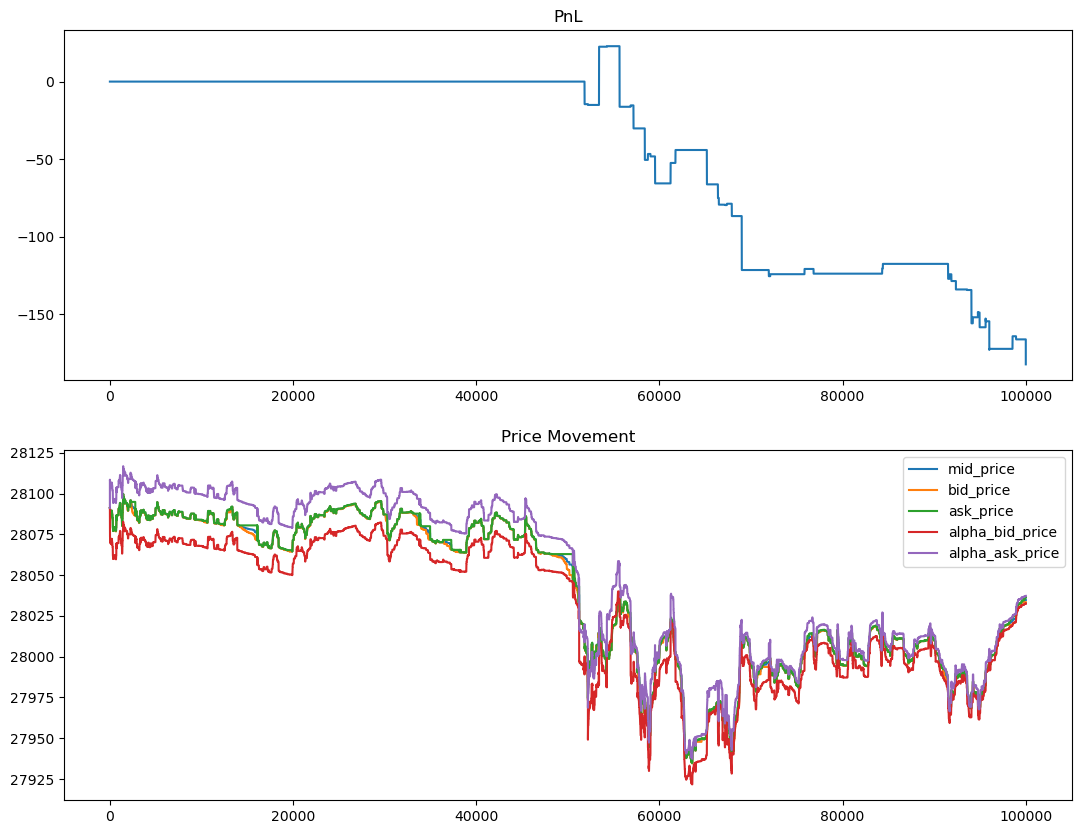

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(13, 10))

axes[0].plot(run_data['pnl_history'])
axes[0].set_title('PnL')

axes[1].plot(run_data['mid_prices'], label='mid_price')
axes[1].plot(run_data['bid_prices'], label='bid_price')
axes[1].plot(run_data['ask_prices'], label='ask_price')
axes[1].plot(run_data['my_bid_prices'], label='alpha_bid_price')
axes[1].plot(run_data['my_ask_prices'], label='alpha_ask_price')
axes[1].set_title('Price Movement')

plt.legend()
plt.show()

In [30]:
agent.BTC, agent.USDT

(-1.6770000000000003, 46846.40149999998)

In [34]:
agent.USDT + agent.BTC * order_book.bid_price()

-165.61030000002938